In [246]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

Filter Data According to badSampleIdxList txt file

In [247]:
# filter 
def filterBadData(X_dataset, y_dataset, badSampleIdxListTXT):
    teleportation_threshold = 0.2 # allowed maximum teleportation distance
    for i in range(TIME_STEPS-1):

        diff_x = X_dataset[:, 2*i] - X_dataset[:, 2*i+2]
        diff_y = X_dataset[:, 2*i+1] - X_dataset[:, 2*i+3]
        dist = diff_x * diff_x + diff_y * diff_y
        filt = dist > (teleportation_threshold * teleportation_threshold)
        X_dataset[filt, 2*i+2] = X_dataset[filt, 2*i]
        X_dataset[filt, 2*i+3] = X_dataset[filt, 2*i+1]

    # remove records that have only outliers
    amplitute = np.sum(np.abs(X_dataset), axis=1)
    filt = amplitute > 0.01
    X_dataset = X_dataset[filt]
    y_dataset = y_dataset[filt]

    if badsampleIdxFile:
        badSampleIdxList = np.loadtxt(badSampleIdxListTXT)
        filt = np.ones(len(X_dataset), dtype=bool)
        for idx in badSampleIdxList:
            idx = int(idx)
            filt[idx] = False

        X_dataset = X_dataset[filt]
        y_dataset = y_dataset[filt]

    return X_dataset, y_dataset


# 各パス指定

30 interval Dense

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier_linear.hdf5'

30 interval LSTM

In [23]:
dataset = 'model/point_history_classifier/point_history_xinyang.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM.hdf5'
label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Cross", "Right", "Left"]

In [58]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM.hdf5'
label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Cross", "Right", "Left"]

In [248]:
data_twoPeople = [
    'model/point_history_classifier/point_history.csv', 
    # 'model/point_history_classifier/point_history_xinyang.csv'
    ]
badSampleIdxList_twoPeople = [
    "badSampleIdxList_yipeng.txt", 
    # "badSampleIdxList_xinyang.txt"
    ]
# model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_2P.hdf5'
model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM.hdf5'
label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Cross", "Right", "Left"]

16 interval Dense

In [130]:
dataset = 'model/point_history_classifier/point_history_16interval.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier_16interval_linear.hdf5'


16 interval LSTM

In [60]:
dataset = 'model/point_history_classifier/point_history_16interval.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier_16interval_LSTM.hdf5'


# 分類数設定

In [249]:
NUM_CLASSES = 6

# 入力長

In [250]:
TIME_STEPS = 30 #16 or 30
DIMENSION = 2

# 学習データ読み込み

In [240]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
X_dataset.shape

(2409, 60)

In [241]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

Call if we want to load the datasets from the twoPeople's csv files

In [251]:
X_list = []
y_list = []
for csvfileName, badsampleIdxFile in zip(data_twoPeople, badSampleIdxList_twoPeople):
    X_dataset = np.loadtxt(csvfileName, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
    y_dataset = np.loadtxt(csvfileName, delimiter=',', dtype='int32', usecols=(0))

    X_dataset, y_dataset = filterBadData(X_dataset, y_dataset, badsampleIdxFile)
    X_list.append(X_dataset)
    y_list.append(y_dataset)

X_dataset = np.vstack(X_list)
y_dataset = np.concatenate(y_list)
X_dataset.shape, y_dataset.shape

((2093, 60), (2093,))

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

807 Checkmark


(2093, 60)

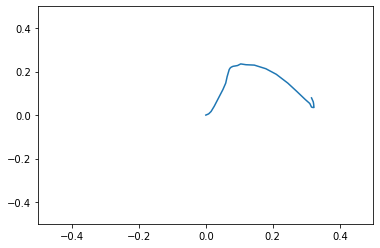

In [253]:
from matplotlib import pyplot as plt

idx = np.random.randint(800, 1000)

x = X_dataset[idx,::2]
y = X_dataset[idx,1::2]
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
print(idx, label_names[y_dataset[idx]])
plt.plot(x, y)
X_dataset.shape

2093
[357, 361, 358, 315, 356, 346]


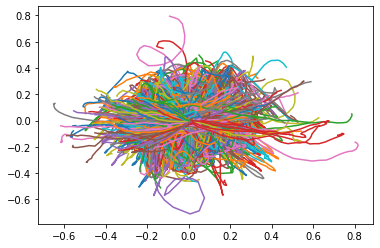

In [254]:
from matplotlib import pyplot as plt
idx = np.random.randint(0, 2000)
count = 0
label_count = [0]*6
for idx in range(len(X_dataset)):
    x = X_dataset[idx,::2]
    y = X_dataset[idx,1::2]
    label_count[y_dataset[idx]-1] += 1
    # print(y_dataset[idx], label_names[y_dataset[idx]])
    plt.plot(x, y)
    count += 1
print(count)
print(label_count)
# plt.plot(x,y)


# モデル構築

In [255]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.1), #0.2
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]), # 16 previous
        tf.keras.layers.Dropout(0.2), #0.5
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2), #0.2
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dropout(0.5), #0.5
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [256]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 30, 2)             0         
                                                                 
 dropout_22 (Dropout)        (None, 30, 2)             0         
                                                                 
 lstm_11 (LSTM)              (None, 16)                1216      
                                                                 
 dropout_23 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 20)                340       
                                                                 
 dense_23 (Dense)            (None, 6)                 126       
                                                                 
Total params: 1,682
Trainable params: 1,682
Non-train

In [257]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=1000, verbose=1)

In [258]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [259]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 8/13 [=================>............] - ETA: 0s - loss: 1.7873 - accuracy: 0.2148 
Epoch 00001: saving model to model/point_history_classifier\point_history_classifier_LSTM.hdf5
13/13 [==============================] - 2s 51ms/step - loss: 1.7848 - accuracy: 0.2454 - val_loss: 1.7768 - val_accuracy: 0.3645
Epoch 2/1000
 9/13 [===================>..........] - ETA: 0s - loss: 1.7749 - accuracy: 0.3203
Epoch 00002: saving model to model/point_history_classifier\point_history_classifier_LSTM.hdf5
13/13 [==============================] - 0s 11ms/step - loss: 1.7734 - accuracy: 0.3180 - val_loss: 1.7660 - val_accuracy: 0.3702
Epoch 3/1000
 9/13 [===================>..........] - ETA: 0s - loss: 1.7633 - accuracy: 0.3273
Epoch 00003: saving model to model/point_history_classifier\point_history_classifier_LSTM.hdf5
13/13 [==============================] - 0s 10ms/step - loss: 1.7617 - accuracy: 0.3359 - val_loss: 1.7523 - val_accuracy: 0.3798
Epoch 4/1000
 9/13 [================

In [260]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [261]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[5.8473656e-06 1.0912607e-06 1.3777790e-04 3.6831403e-05 5.1055810e-07
 9.9981803e-01]
5


# 混同行列

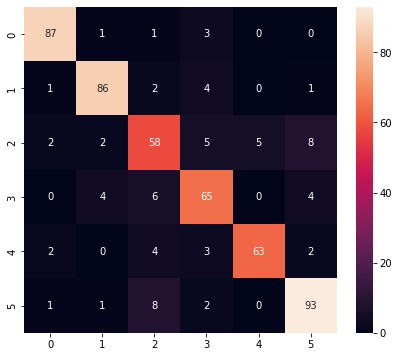

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        92
           1       0.91      0.91      0.91        94
           2       0.73      0.72      0.73        80
           3       0.79      0.82      0.81        79
           4       0.93      0.85      0.89        74
           5       0.86      0.89      0.87       105

    accuracy                           0.86       524
   macro avg       0.86      0.86      0.86       524
weighted avg       0.86      0.86      0.86       524



In [262]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [220]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [221]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier_2P.tflite'

In [222]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open(tflite_save_path, 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\linyi\AppData\Local\Temp\tmpx_3bj9q5\assets


INFO:tensorflow:Assets written to: C:\Users\linyi\AppData\Local\Temp\tmpx_3bj9q5\assets


14992

# 推論テスト

In [223]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [224]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_11:0', 'index': 0, 'shape': array([ 1, 60]), 'shape_signature': array([-1, 60]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [225]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [226]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 1.98 ms


In [227]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.91341192e-03 1.93613872e-03 1.13033675e-01 8.63234580e-01
 4.45278332e-04 1.14368945e-02]
3
